# Implementação de LSTM com Embedding Layer de NLU

Este é um notebook Python com a implementação de Modelo com LSTM Layer e RNN com Embedding Layer de Natural Language Understanding (NLU), que é um classificador de intenções (i.e., classificador de intenção baseada em um texto de entrada).

## Como executar
Para executar esse notebook com CPU ou GPU siga os passos abaixo:

Caso esteja rodando localmente execute o comando pip install -r requirements.txt para download de todas as dependências necessárias e vá para o passo 4.

1. Baixe este notebook e importe para o Google Colab

2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"

3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. Escolha a que deseja utilizar (caso esteja em uma conta gratuita, apenas CPU e a T4 GPU estarão disponíveis). Clique em "OK" caso um pop-up apareça. Dica: GPUs são mais rápidas.

4. Execute a seção Importação de dependências para baixar todas as dependências necessárias.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.</strong>

## Setup inicial

### Importar as bibliotecas necessárias

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import time
import json
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

### Carregar os Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Dados/processed/dados_agregados_2.csv"
dataset = pd.read_csv(file_path)
dataset.head(3)

In [4]:
# drop rows with intentions appearing once
dataset = dataset.groupby('Intencao').filter(lambda x: len(x) > 2)


# 1 - Definição da função de treinamento do classificador com seus respectivos testes;

## Pré-processamento (rotulagem, divisão do dataset, tokenização)

In [5]:
# Extrair as colunas relevantes
X = dataset['processed_pergunta'].apply(lambda x: ' '.join(literal_eval(x)))

y = dataset['Intencao']

# Fazer o encoding das labels/rotulos (Intencao) como números inteiros
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir os dados em dataset de treinamento e de validação
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y)

# Fazer a tokenização do texto e transformar em sequências textuais com o próprio Tokenizer fornecido pelo Keras
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Fazer o padding das sequências textuais para que tenham o mesmo tamanho
max_sequence_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_len, padding='post')

# Converter labels (y) para dado categórico (com one-hot encoding para classificação multiclasse)
num_classes = len(label_encoder.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

## Construir uma Rede Neural Recorrente (RNN) com Embedding Layer e LSTM Layer

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64), # Embedding Layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM Layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train_pad, y_train_cat, epochs=50, validation_data=(X_val_pad, y_val_cat))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1955 - loss: 2.7522 - val_accuracy: 0.2900 - val_loss: 2.4957
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2659 - loss: 2.4672 - val_accuracy: 0.3050 - val_loss: 2.3354
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3289 - loss: 2.3657 - val_accuracy: 0.3900 - val_loss: 2.1205
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4253 - loss: 2.0483 - val_accuracy: 0.4950 - val_loss: 1.7661
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4953 - loss: 1.7482 - val_accuracy: 0.5500 - val_loss: 1.5782
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5529 - loss: 1.4559 - val_accuracy: 0.6150 - val_loss: 1.3502
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6226 - loss: 1.2047 - val_accuracy: 0.6550 - val_loss: 1.1623
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6936 - loss: 1.0183 - val_accuracy: 0.6700 - val_loss

## Avaliar o modelo

In [39]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_val_pad, y_val_cat)
print(f'Acurácia do Set de Validação: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9165 - loss: 0.6061 
Acurácia do Set de Validação: 0.9200000166893005


## Respectivos testes da função de treinamento do classificador

In [23]:
import unittest

class TestModelTraining(unittest.TestCase):
    def setUp(self):
        # Definir variáveis como num_classes e dados de entrada fictícios para o teste
        self.num_classes = 10
        self.max_len = 100
        self.vocab_size = 5000

        # Gerar dados aleatórios para X_train_pad, y_train_cat, X_val_pad, y_val_cat
        self.X_train_pad = np.random.randint(0, self.vocab_size, size=(100, self.max_len))
        self.y_train_cat = np.random.randint(0, self.num_classes, size=(100,))
        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train_cat, num_classes=self.num_classes)

        self.X_val_pad = np.random.randint(0, self.vocab_size, size=(20, self.max_len))
        self.y_val_cat = np.random.randint(0, self.num_classes, size=(20,))
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val_cat, num_classes=self.num_classes)

        # Definir o modelo que será testado
        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=64),  # Embedding Layer
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),              # LSTM Layer
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compilar o modelo
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def test_model_compilation(self):
        # Verificar se o modelo foi compilado corretamente
        self.assertIsNotNone(self.model.optimizer, "O otimizador não foi inicializado corretamente.")
        self.assertEqual(self.model.loss, 'categorical_crossentropy', "Função de perda não configurada corretamente.")

    def test_model_training(self):
        # Treinar o modelo com 1 época para verificar se ele treina sem erros
        history = self.model.fit(self.X_train_pad, self.y_train_cat, epochs=1, validation_data=(self.X_val_pad, self.y_val_cat), verbose=0)

        # Verificar se a função de perda e a acurácia estão retornando valores
        self.assertIn('loss', history.history, "Histórico de treinamento não contém perda.")
        self.assertIn('accuracy', history.history, "Histórico de treinamento não contém acurácia.")
        self.assertIn('val_loss', history.history, "Histórico de validação não contém perda.")
        self.assertIn('val_accuracy', history.history, "Histórico de validação não contém acurácia.")

        # Verificar se a perda do treinamento foi atualizada
        train_loss = history.history['loss'][0]
        self.assertGreater(train_loss, 0, "A perda de treinamento não foi atualizada corretamente.")

        # Verificar se a acurácia foi registrada
        train_acc = history.history['accuracy'][0]
        self.assertGreaterEqual(train_acc, 0, "A acurácia de treinamento não foi registrada corretamente.")


if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    print("Todos os testes foram completados.")

.
----------------------------------------------------------------------
Ran 2 tests in 4.210s

OK


Todos os testes foram completados.


# 2 - Otimização de parâmetros para treinamento do modelo e apresentação de gráficos para analisar se está ocorrendo overfitting ou underfitting;

## Avaliação do modelo sem otimização de parâmetros

### Gráfico de acurácia de treino e de validação

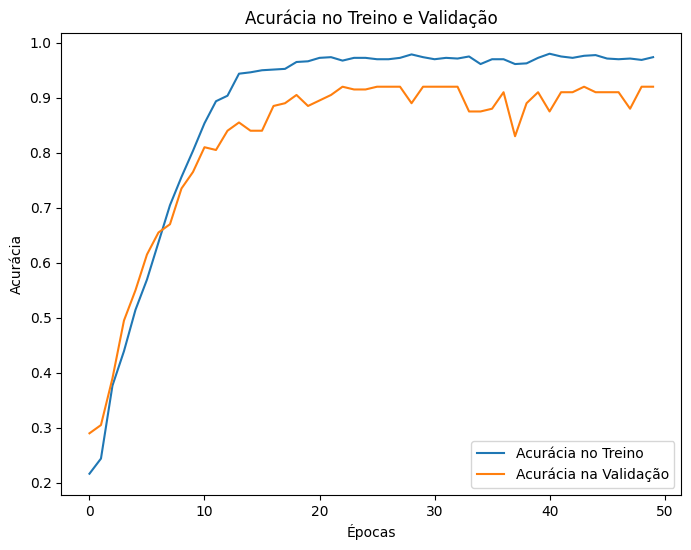

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Acurácia no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Gráfico da função de perda para dataset de treino e de validação

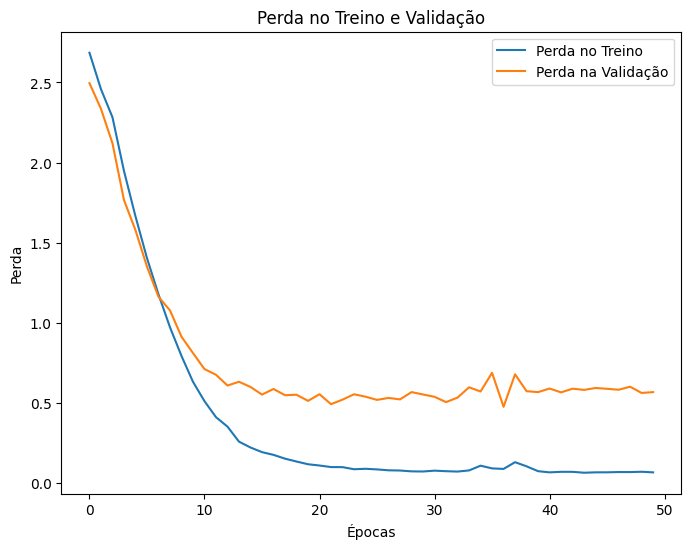

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda no Treino')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Perda no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

## Análise

Conforme slide abaixo, extraído da aula "Diagnosing bias and variance" da [Especialização de Machine Learning da DeepLearning.AI](https://www.coursera.org/learn/advanced-learning-algorithms/home/week/3), não temos uma situação em que ocorre uma variância expressiva (overfitting) ou se identifica alto viés (underfitting), pois tanto a perda no treino quanto no dataset de validação são relativamente baixos.

De qualquer forma, vamos buscar reduzir a diferença entre a validação no treino e na validação com algumas técnicas de otimização e prevenção de overfitting.

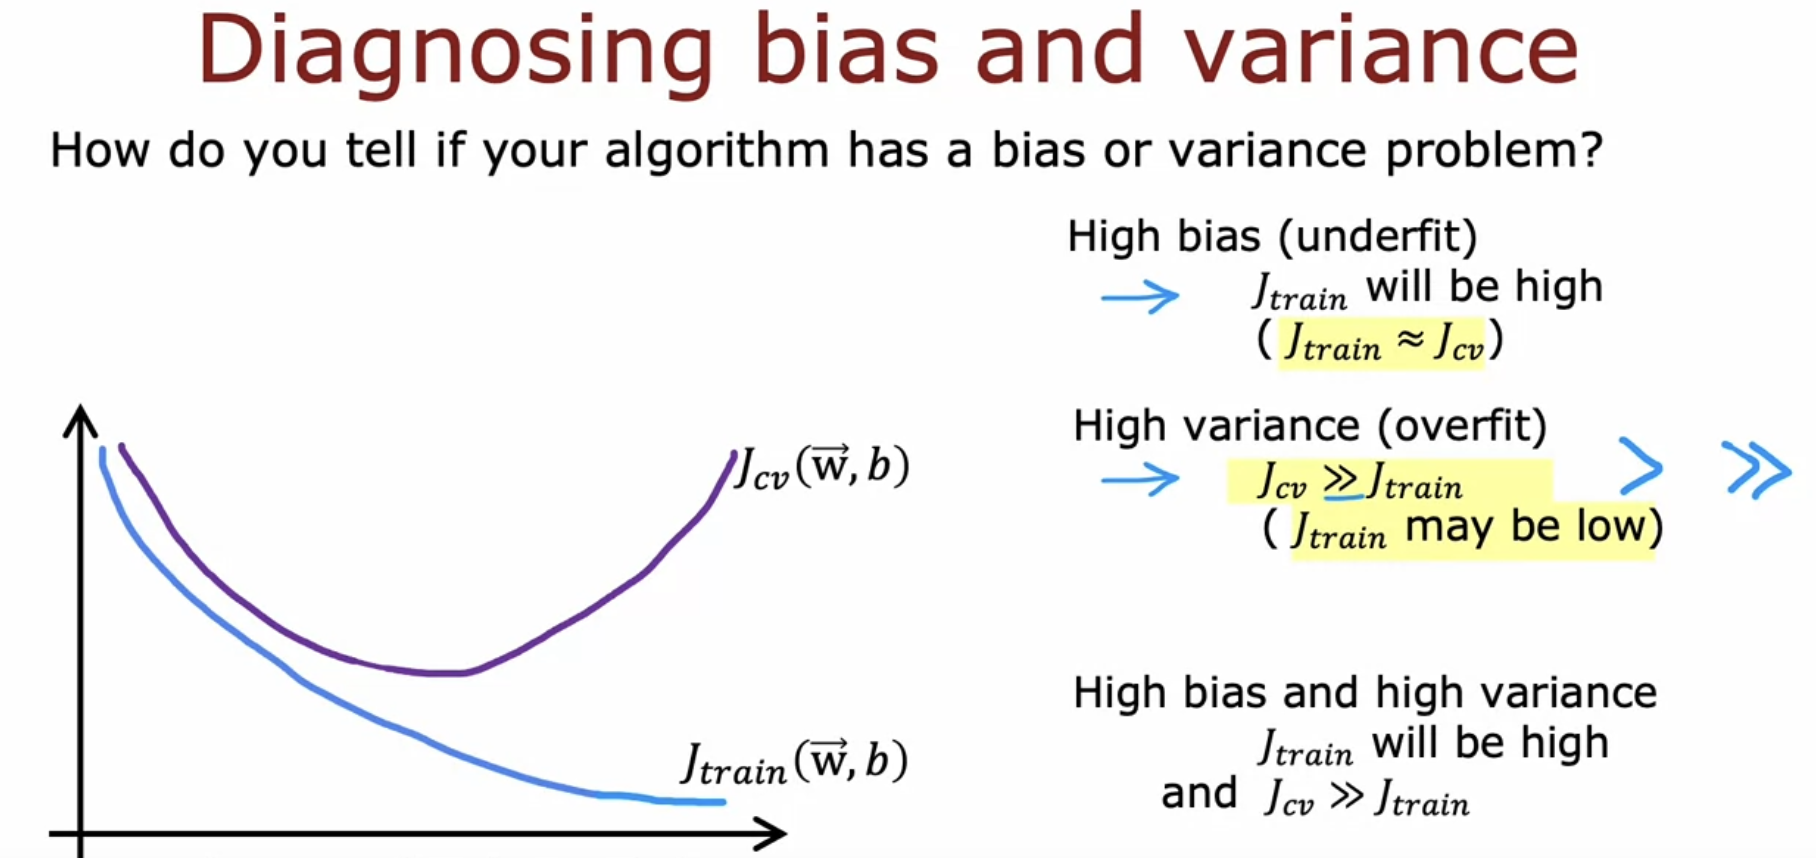

## Otimização de parâmetros

Vamos introduzir algumas técnicas para tentar reduzir a variância.

- O dropout é usado para evitar overfitting, descartando unidades aleatoriamente durante o treinamento.
- O "early stopping" ajuda a evitar o overfitting, interrompendo o treinamento quando o desempenho da validação começa a degradar.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Treinar com early stopping
history = model.fit(X_train_pad, y_train_cat,
                    epochs=100,
                    validation_data=(X_val_pad, y_val_cat),
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.1491 - loss: 2.7552 - val_accuracy: 0.2400 - val_loss: 2.5129
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2129 - loss: 2.5797 - val_accuracy: 0.2400 - val_loss: 2.4484
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2555 - loss: 2.4810 - val_accuracy: 0.3200 - val_loss: 2.2847
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3654 - loss: 2.2035 - val_accuracy: 0.4200 - val_loss: 1.9107
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4284 - loss: 1.9479 - val_accuracy: 0.4650 - val_loss: 1.6613
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5181 - loss: 1.5997 - val_accuracy: 0.5950 - val_loss: 1.5306
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5322 - loss: 1.5039 - val_accuracy: 0.6250 - val_loss: 1.3338
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6056 - loss: 1.2818 - val_accuracy: 0.

## Avaliação do modelo com otimização de parâmetros

Uma vez adotadas essas técnicas é possível identificar através de gráficos que o problema de overfitting foi amenizado, porém ao custo de acurácia.

Nesse caso, o trade-off entre variância e acurácia não foi interessante e optamos, portanto, por manter o modelo original.

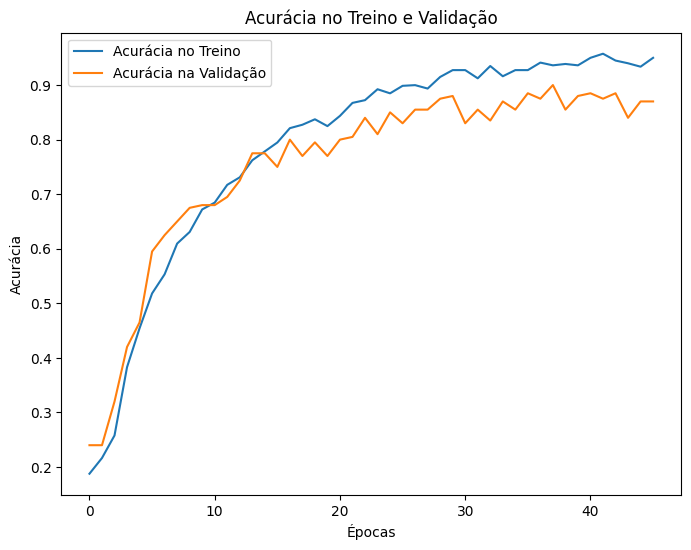

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Acurácia no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

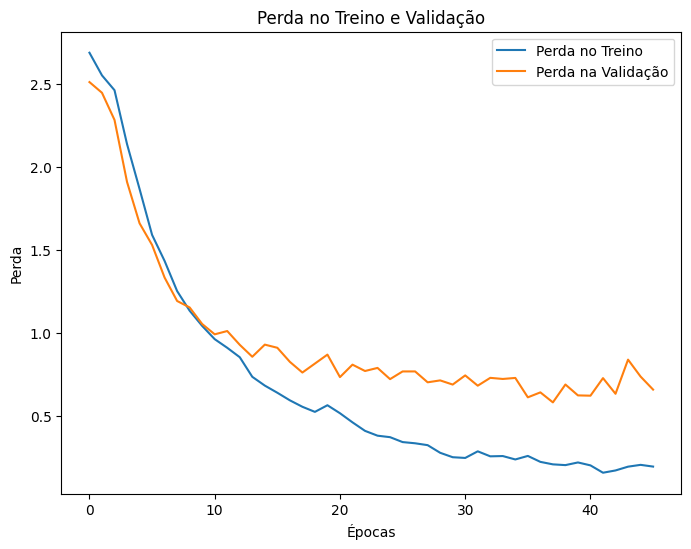

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda no Treino')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Perda no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [14]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_val_pad, y_val_cat)
print(f'Acurácia do Set de Validação: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8532 - loss: 0.5843 
Acurácia do Set de Validação: 0.8600000143051147


## 3 - Treinamento do classificador com apresentação da matriz de confusão, sua respectiva descrição e análise, além de métricas escolhidas para avaliar a qualidade do modelo

Descrição: A matriz de confusão é uma tabela que permite visualizar o desempenho do modelo de classificação, comparando as predições do modelo com os valores reais das classes.

Análise: No modelo atual, a matriz de confusão apresentou acertos significativos, com pequenas divergências em algumas categorias como "Cadastro de beneficiário" e "Como depositar". Isso é compatível com a alta acurácia identificada (cerca de 92%).

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


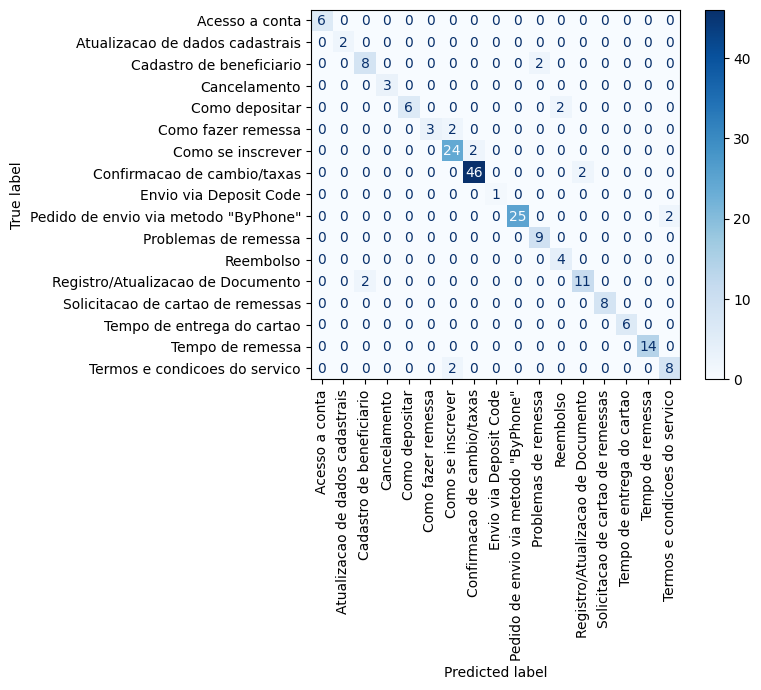

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_val_pred_probs = model.predict(X_val_pad)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

## Métricas

In [44]:
report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_, zero_division=1)
print(report)

                                      precision    recall  f1-score   support

                      Acesso a conta       1.00      1.00      1.00         6
     Atualizacao de dados cadastrais       1.00      1.00      1.00         2
            Cadastro de beneficiario       0.80      0.80      0.80        10
                        Cancelamento       1.00      1.00      1.00         3
                      Como depositar       1.00      0.75      0.86         8
                  Como fazer remessa       1.00      0.60      0.75         5
                   Como se inscrever       0.86      0.92      0.89        26
         Confirmacao de cambio/taxas       0.96      0.96      0.96        48
              Envio via Deposit Code       1.00      1.00      1.00         1
Pedido de envio via metodo "ByPhone"       1.00      0.93      0.96        27
                Problemas de remessa       0.82      1.00      0.90         9
                           Reembolso       0.67      1.00      

# 4 - Instruções para treinamento do modelo com CPU e GPU no Google Colab e treinamento do modelo com as duas alternativas, com análise comparando as duas alternativas.

Instruções: Crie um ambiente no Google Colab com uma CPU ou a respectiva GPU (T4 / A100) e execute os blocos abaixo para executar o treinamento do modelo conforme o ambiente.


In [6]:
root_dir = "/content/drive/MyDrive/Dados/"
try:
    with open(root_dir + "execution_times_lstm.json", "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

In [8]:
def memory_usage_psutil():
    """
        Returns the memory usage of the process in MB
    """
    try:
      process = psutil.Process()
      mem = process.memory_info().rss / float(2 ** 20)  # em MB
      return mem
    except Exception as e:
        print(f"Erro ao calcular a memória: {e}")
        raise

## CPU

In [9]:
num_samples = 3

all_times = 0
all_mem = 0

for i in range(num_samples):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=64), # Embedding Layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM Layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    cpu_start_time = time.time()
    cpu_start_mem = memory_usage_psutil()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train_pad, y_train_cat, epochs=40, validation_data=(X_val_pad, y_val_cat))

    cpu_mem = memory_usage_psutil() - cpu_start_mem

    cpu_time = time.time() - cpu_start_time

    all_times += cpu_time
    all_mem += cpu_mem

cpu_time = all_times / num_samples
cpu_mem = all_mem / num_samples

data["CPU"] = {
    "execution_time": cpu_time,
    "memory_usage": cpu_mem
}

with open(root_dir + "execution_times_lstm.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.1351 - loss: 2.7559 - val_accuracy: 0.2900 - val_loss: 2.4798
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2899 - loss: 2.5428 - val_accuracy: 0.2400 - val_loss: 2.3952
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2910 - loss: 2.3385 - val_accuracy: 0.3500 - val_loss: 2.1845
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3851 - loss: 2.0909 - val_accuracy: 0.4200 - val_loss: 1.8663
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4869 - loss: 1.7536 - val_accuracy: 0.5200 - val_loss: 1.6065
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5467 - loss: 1.4851 - val_accuracy: 0.5600 - val_loss: 1.4522
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6330 - loss: 1.2254 - val_accuracy: 0.5850 - val_loss: 1.3117
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6665 - loss: 1.1360 - val_accuracy: 0.5950 - v

## T4 GPU

In [25]:
num_samples = 3

all_times = 0
all_mem = 0

for i in range(num_samples):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=64), # Embedding Layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM Layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


    t4_start_time = time.time()
    t4_start_mem = memory_usage_psutil()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_cat, epochs=40, validation_data=(X_val_pad, y_val_cat))

    t4_mem = memory_usage_psutil() - t4_start_mem

    t4_time = time.time() - t4_start_time
    all_times += t4_time
    all_mem += t4_mem

t4_time = all_times / num_samples
t4_mem = all_mem / num_samples

data["T4 GPU"] = {
    "execution_time": t4_time,
    "memory_usage": t4_mem
}

with open(root_dir + "execution_times_lstm.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2176 - loss: 2.7211 - val_accuracy: 0.2400 - val_loss: 2.4761
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2346 - loss: 2.5125 - val_accuracy: 0.3300 - val_loss: 2.3397
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3407 - loss: 2.2955 - val_accuracy: 0.4200 - val_loss: 2.0198
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4188 - loss: 1.9679 - val_accuracy: 0.4500 - val_loss: 1.7864
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4998 - loss: 1.6519 - val_accuracy: 0.4900 - val_loss: 1.5441
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5842 - loss: 1.3703 - val_accuracy: 0.6000 - val_loss: 1.2785
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6463 - loss: 1.1961 - val_accuracy: 0.6950 - val_loss: 1.0577
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7236 - loss: 0.9418 - val_accuracy: 0.6900 - val_loss

## A100 GPU

In [48]:
num_samples = 3

all_times = 0
all_mem = 0

for i in range(num_samples):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=64), # Embedding Layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # LSTM Layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    a100_start_time = time.time()
    a100_start_mem = memory_usage_psutil()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_cat, epochs=40, validation_data=(X_val_pad, y_val_cat))

    a100_mem = memory_usage_psutil() - a100_start_mem

    a100_time = time.time() - a100_start_time

    all_times += a100_time
    all_mem += a100_mem

a100_time = all_times / num_samples
a100_mem = all_mem / num_samples

data["A100 GPU"] = {
    "execution_time": a100_time,
    "memory_usage": a100_mem
}

with open(root_dir + "execution_times_lstm.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1970 - loss: 2.7423 - val_accuracy: 0.2400 - val_loss: 2.4609
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3032 - loss: 2.4346 - val_accuracy: 0.3200 - val_loss: 2.3338
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3212 - loss: 2.2951 - val_accuracy: 0.3250 - val_loss: 2.0484
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4000 - loss: 1.9107 - val_accuracy: 0.4750 - val_loss: 1.7417
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5434 - loss: 1.6249 - val_accuracy: 0.5550 - val_loss: 1.4511
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6242 - loss: 1.2713 - val_accuracy: 0.6050 - val_loss: 1.2736
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6819 - loss: 1.0504 - val_accuracy: 0.6800 - val_loss: 1.1176
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7510 - loss: 0.8891 - val_accuracy: 0.7050 - val_loss

## Análise

### Tempo de execução

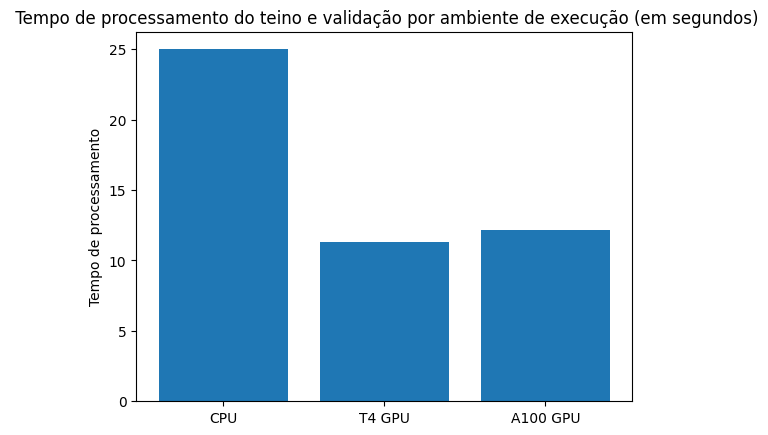

In [11]:
fig, ax = plt.subplots()

cpu_time = data["CPU"]["execution_time"]
t4_time = data["T4 GPU"]["execution_time"]
a100_time = data["A100 GPU"]["execution_time"]

shapes = [cpu_time, t4_time, a100_time]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Tempo de processamento")
ax.set_title(" Tempo de processamento do treino e validação por ambiente de execução (em segundos)")

plt.show()

É possível notar que as GPU (T4 e A100) apresentaram um tempo de processamento considerável menor do que a CPU. Isso era esperado pelo fato das GPUs conseguirem processar as operações de machine learning paralelamente, acelerando o processo de treinamento.

### Uso de memória

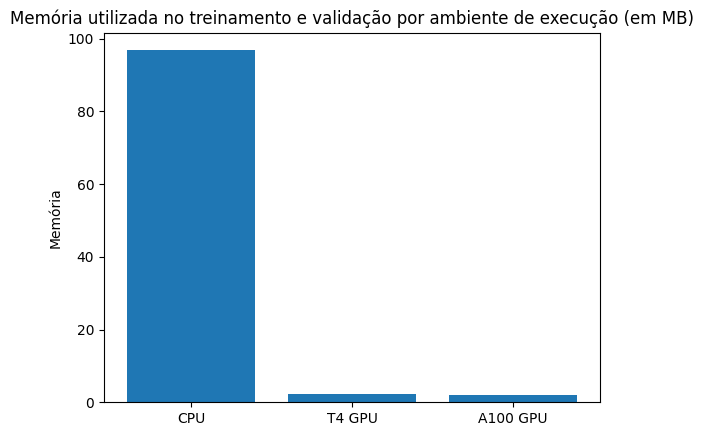

In [12]:
fig, ax = plt.subplots()

cpu_mem = data["CPU"]["memory_usage"]
t4_mem = data["T4 GPU"]["memory_usage"]
a100_mem = data["A100 GPU"]["memory_usage"]

shapes = [cpu_mem, t4_mem, a100_mem]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Memória")
ax.set_title("Memória utilizada no treinamento e validação por ambiente de execução (em MB)")

plt.show()

É possível notar que as GPUs apresentaram um uso de memória RAM muito inferior ao da CPU,por executar as operaçoes na memória da GPU.

Conclusão: A GPU se apresentou como uma melhor solução para este problema por usar menos memória.